<a href="https://colab.research.google.com/github/Ziad-o-Yusef/Deep-learning-notes/blob/main/16_GANS_1_Basic_gan_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 ▶ Get Librares  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math 
import cv2
from tqdm import tqdm
import os 
from google.colab import drive 


# 2 ▶ Get & Handeling Dataset 


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle_MyAPI'

In [4]:
! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 79% 12.0M/15.1M [00:00<00:00, 64.4MB/s]
100% 15.1M/15.1M [00:00<00:00, 74.3MB/s]


In [5]:
%mkdir /content/Dataset
%cd /content/Dataset

/content/Dataset


In [ ]:
! unzip /content/brain-mri-images-for-brain-tumor-detection.zip

In [7]:
%cd ..

/content


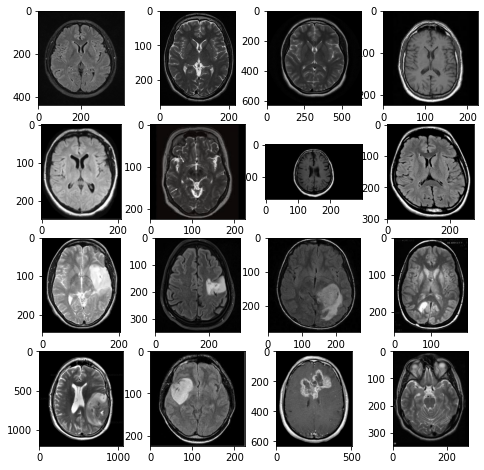

In [8]:
dir = '/content/Dataset'
dirs = os.listdir(dir)
imshow_dirs = []
for i in dirs : 
    step = os.listdir(dir+ '/'+ i)
    for x in range(8):
        try : 
          imshow_dirs.append(dir+ '/' + i + '/' + step[x])
        except : 
          continue
fig, ax = plt.subplots(4,4,figsize=(8,8))
for n in range(4):
    for m in range(4):
        path =imshow_dirs[m + 4*n]
        image = cv2.imread(str(path))
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [9]:
cv2.imread(imshow_dirs[0]).shape

(442, 400, 3)

In [2]:
X = []
Y = []
for i in os.listdir('/content/brain_tumor_dataset'):
  path = '/content/brain_tumor_dataset/'+ i
  for x in os.listdir(path):
    img = cv2.imread(path + '/'+ x)
    img = cv2.resize(img,(128, 128), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(128,128,1)
    X.append(img)
    Y.append(i)
X = np.array(X)
Y = np.array(Y)
X.shape , Y.shape

((253, 128, 128, 1), (253,))

In [29]:
X = (X.astype(np.float32) - 127.5)/127.5
X = X.reshape(253, 128*128)

# 3 ▶ Start to GANs  

## 3.0 | Important Reference nums

In [35]:
# importent nums 
random_dim = 100
np.random.seed(10)
image_dim = 128 * 128 * 1

## 3.1 | Generator Structure

In [36]:
def get_generator():
  gen = tf.keras.Sequential()
  gen.add(tf.keras.layers.Dense(265,input_dim = random_dim))
  gen.add(tf.keras.layers.LeakyReLU(0.2))
  gen.add(tf.keras.layers.Dense(512))
  gen.add(tf.keras.layers.LeakyReLU(0.2))
  gen.add(tf.keras.layers.Dense(1024))
  gen.add(tf.keras.layers.LeakyReLU(0.2))
  gen.add(tf.keras.layers.Dense(image_dim, activation='tanh'))
  gen.compile(loss='binary_crossentropy', optimizer='rmsprop')
  return gen 

get_generator().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 265)               26765     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 265)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               136192    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 16384)            

## 3.2 | Discriminator Structure

In [37]:
def get_discriminator():
    disc = tf.keras.Sequential()
    disc.add(tf.keras.layers.Dense(1024, input_dim=image_dim))
    disc.add(tf.keras.layers.LeakyReLU(0.2))
    disc.add(tf.keras.layers.Dropout(0.3))
    disc.add(tf.keras.layers.Dense(512))
    disc.add(tf.keras.layers.LeakyReLU(0.2))
    disc.add(tf.keras.layers.Dropout(0.3))
    disc.add(tf.keras.layers.Dense(256))
    disc.add(tf.keras.layers.LeakyReLU(0.2))
    disc.add(tf.keras.layers.Dropout(0.3))
    disc.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    disc.compile(loss='binary_crossentropy', optimizer='rmsprop')  
    return disc

get_discriminator().summary()   

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              16778240  
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

## 3.3 | GAN Network Structure

In [38]:
def get_gan_network(disc,gen):
  disc.trainable = False
  gan_input = tf.keras.layers.Input(shape=(random_dim))
  x = gen(gan_input)
  gan_output = disc(x)
  gan = tf.keras.models.Model(inputs=gan_input, outputs=gan_output)
  gan.compile(loss='binary_crossentropy', optimizer='adam')
  return gan

## 3.4 | Training Function

In [40]:
def training(epochs = 5, batch_size = 128):

  batch_count = X.shape[0] / batch_size

  generator = get_generator()
  discriminator = get_discriminator()
  gan = get_gan_network(discriminator,generator)

  for epoch in range(1, epochs+1):
    print('-'*25, 'Epoch %d' % epoch, '-'*25)

    for _ in tqdm(range(int(batch_count))):
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      image_batch = X[np.random.randint(0, X.shape[0], size=batch_size)]

      generated_images = generator.predict(noise)
      concat = np.concatenate([image_batch, generated_images])

      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9

      discriminator.trainable = True
      discriminator.train_on_batch(concat, y_dis)

      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_gen)
      if epoch == 1 or epoch % 20 == 0:
          plot_generated_images(epoch, generator)

## 3.4 | Plot GAN Results function

In [47]:
def plot_generated_images(epoch, generator, examples=36, dim=(6, 6), figsize=(6, 6)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, math.sqrt(image_dim), math.sqrt(image_dim))
    print("#==========================================================================================================#")
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

## 3.5 | Trainig & Results

In [ ]:
training(epochs=1000)

In [ ]:
result = cv2.imread('') # Result image
cv2.imshow(result)

# 4 ▶ Import  `basic_gans_module_ `

In [7]:
import basic_gans_module_

In [8]:
bgm = basic__gans_model_python.BasicGANsModel(X,100)

In [10]:
bgm.how_to_work()


        1- Create Object from BasicGANsModel()
        2- set your X dataset (Images) & dim for the generated image in your instance 
        3- call training func() and set  => num of epchs (defult = 10) , => batch size (defult = 128)
        notes : 
        - your dataset should be grayscle 
        - your images should be same & equality size - like (28,28,1)
        THANK YOU :D
        


------------------------- Epoch 1 -------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


------------------------- Epoch 2 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


------------------------- Epoch 3 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


------------------------- Epoch 4 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


------------------------- Epoch 5 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


------------------------- Epoch 6 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


------------------------- Epoch 7 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


------------------------- Epoch 8 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


------------------------- Epoch 9 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


------------------------- Epoch 10 -------------------------


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


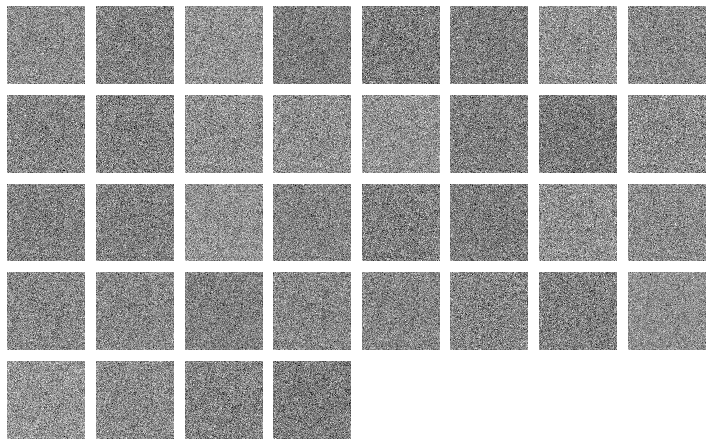

In [9]:
bgm.training(10)